In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
# Location of your midi filesfiles
midi_path = Path('data/midi/examples')
data_path = Path('data/numpy')
data_save_name = 'musicitem_data_save.pkl'

## Load Data

In [5]:
midi_files = get_files(midi_path, '.mid', recurse=True)
data = MusicDataBunch.from_files(midi_files, data_path, processors=[Midi2ItemProcessor()], bs=4, bptt=128,
                                 encode_position=True, dl_tfms=[batch_position_tfm])

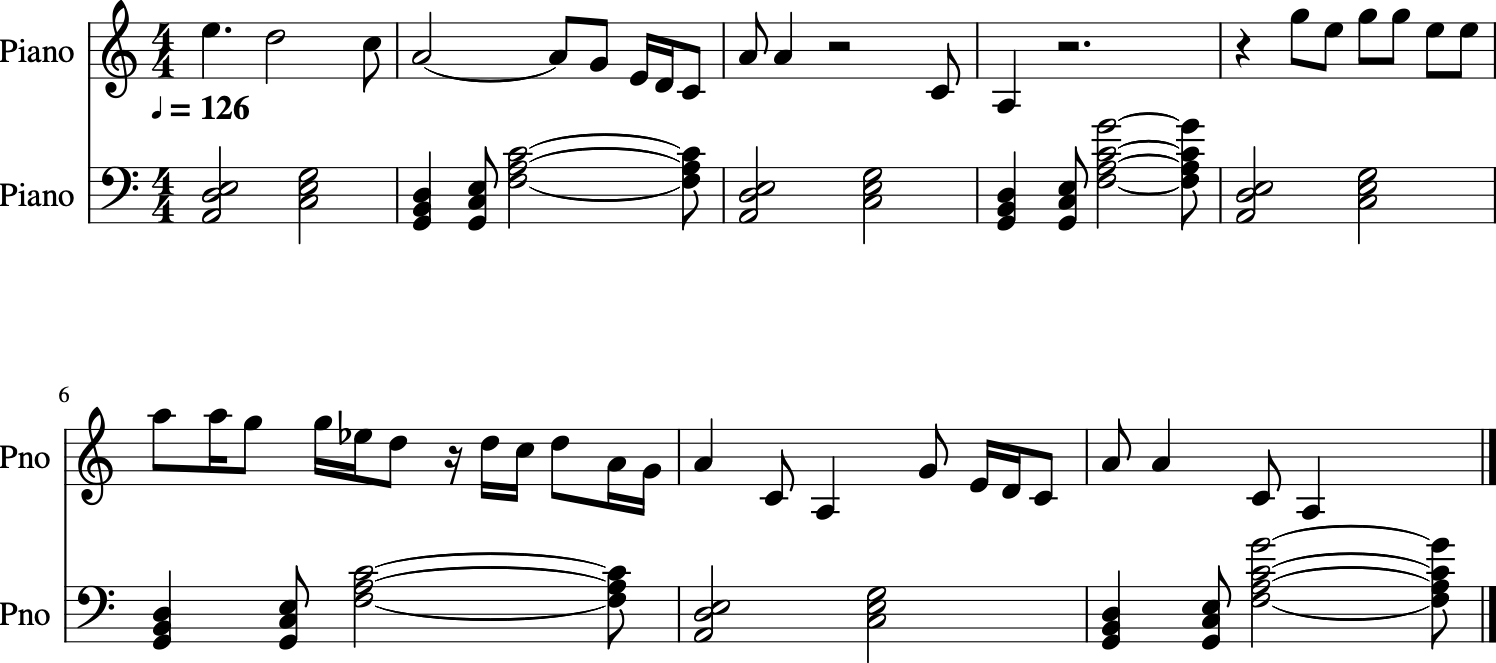

In [6]:
item = MusicItem.from_file(midi_files[0], data.vocab)
item.show()

In [8]:
item.to_text()

'xxbos xxpad n76 d6 n52 d8 n50 d8 n45 d8 xxsep d6 n74 d8 xxsep d2 n55 d8 n52 d8 n48 d8 xxsep d6 n72 d2 xxsep d2 n69 d10 n50 d4 n47 d4 n43 d4 xxsep d4 n52 d2 n48 d2 n43 d2 xxsep d2 n60 d10 n57 d10 n53 d10 xxsep d4 n67 d2 xxsep d2 n64 d1 xxsep d1 n62 d1 xxsep d1 n60 d2 xxsep d2 n69 d2 n52 d8 n50 d8 n45 d8 xxsep d2 n69 d4 xxsep d6 n55 d8 n52 d8 n48 d8 xxsep d6 n60 d2 xxsep d2 n57 d4 n50 d4 n47 d4 n43 d4 xxsep d4 n52 d2 n48 d2 n43 d2 xxsep d2 n67 d10 n60 d10 n57 d10 n53 d10 xxsep d10 n52 d8 n50 d8 n45 d8 xxsep d4 n79 d2 xxsep d2 n76 d2 xxsep d2 n79 d2 n55 d8 n52 d8 n48 d8 xxsep d2 n79 d2 xxsep d2 n76 d2 xxsep d2 n76 d2 xxsep d2 n81 d2 n50 d4 n47 d4 n43 d4 xxsep d2 n81 d1 xxsep d1 n79 d2 xxsep d1 n52 d2 n48 d2 n43 d2 xxsep d1 n79 d1 xxsep d1 n75 d1 n60 d10 n57 d10 n53 d10 xxsep d1 n74 d2 xxsep d3 n74 d1 xxsep d1 n72 d1 xxsep d1 n74 d2 xxsep d2 n69 d1 xxsep d1 n67 d1 xxsep d1 n69 d4 n52 d8 n50 d8 n45 d8 xxsep d4 n60 d2 xxsep d2 n57 d4 xxsep d2 n55 d8 n52 d8 n48 d8 xxsep d2 n67 d2 xxsep d2 n6

In [7]:
item.data

array([  0,   1,  85, 143, ...,   8, 139,  66, 141])

## Training

In [9]:
config = default_config()
config['transpose_range'] = (0, 12) # Data Augmentation
config['encode_position'] = True # Positional Encoding
config['mask_steps'] = 4 # Teacher Forcing

model = get_language_model(arch=MusicTransformerXL, vocab_sz=len(data.vocab), config=config.copy())
learn = MusicLearner(data, model)

In [10]:
# learn.to_fp16(dynamic=True, clip=0.5);
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,3.893180,3.138639,0.203125,00:51
1,3.527709,3.483600,0.162109,00:52
2,3.380569,3.304269,0.162109,00:51
3,3.300186,3.291795,0.162109,00:50


# Better Training

### Data Augmentation (Transpose)
```python
config['transpose_range'] = (0, 12)
```

Data Augmentation is a dataset multiplier

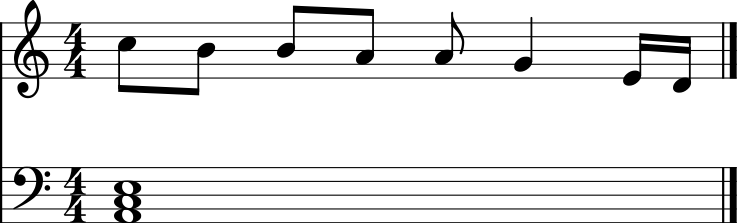

In [11]:
midi_file = Path('data/midi/notebook_examples/single_bar_example.mid')
item = MusicItem.from_file(midi_file, data.vocab).split_parts()
item.show() # Key of C

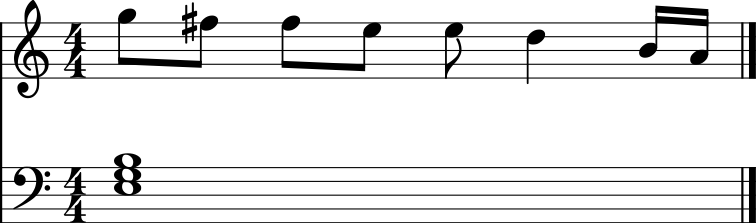

In [13]:
item_transpose = item.transpose(7) # key of G
item_transpose.split_parts().show()

In [14]:
item.to_text()

'xxbos xxpad n72 d2 n52 d16 n48 d16 n45 d16 xxsep d2 n71 d2 xxsep d2 n71 d2 xxsep d2 n69 d2 xxsep d2 n69 d2 xxsep d2 n67 d4 xxsep d4 n64 d1 xxsep d1 n62 d1'

In [15]:
item_transpose.to_text()

'xxbos xxpad n79 d2 n59 d16 n55 d16 n52 d16 xxsep d2 n78 d2 xxsep d2 n78 d2 xxsep d2 n76 d2 xxsep d2 n76 d2 xxsep d2 n74 d4 xxsep d4 n71 d1 xxsep d1 n69 d1'

### Positional Encoding

```python
config['encode_position'] = True
```

<img src=https://jalammar.github.io/images/gpt2/gpt2-input-embedding-positional-encoding-3.png width="500">

Adding extra metadata to the embeddings so our model has better sense of musical timing

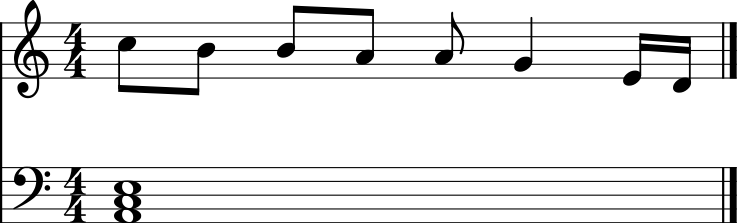

In [16]:
midi_file = Path('data/midi/notebook_examples/single_bar_example.mid')
item = MusicItem.from_file(midi_file, data.vocab).split_parts()
item.show()

In [17]:
index = range(len(item.data))
token_idx = item.data
token_str = item.to_text(sep=None)
beat_position = item.position // 4

In [18]:
print('idx, tok_id, str, position')
list(zip(index, token_idx, token_str, beat_position))

idx, tok_id, str, position


[(0, 0, 'xxbos', 0),
 (1, 1, 'xxpad', 0),
 (2, 81, 'n72', 0),
 (3, 139, 'd2', 0),
 (4, 61, 'n52', 0),
 (5, 153, 'd16', 0),
 (6, 57, 'n48', 0),
 (7, 153, 'd16', 0),
 (8, 54, 'n45', 0),
 (9, 153, 'd16', 0),
 (10, 8, 'xxsep', 0),
 (11, 139, 'd2', 0),
 (12, 80, 'n71', 0),
 (13, 139, 'd2', 0),
 (14, 8, 'xxsep', 0),
 (15, 139, 'd2', 0),
 (16, 80, 'n71', 1),
 (17, 139, 'd2', 1),
 (18, 8, 'xxsep', 1),
 (19, 139, 'd2', 1),
 (20, 78, 'n69', 1),
 (21, 139, 'd2', 1),
 (22, 8, 'xxsep', 1),
 (23, 139, 'd2', 1),
 (24, 78, 'n69', 2),
 (25, 139, 'd2', 2),
 (26, 8, 'xxsep', 2),
 (27, 139, 'd2', 2),
 (28, 76, 'n67', 2),
 (29, 141, 'd4', 2),
 (30, 8, 'xxsep', 2),
 (31, 141, 'd4', 2),
 (32, 73, 'n64', 3),
 (33, 138, 'd1', 3),
 (34, 8, 'xxsep', 3),
 (35, 138, 'd1', 3),
 (36, 71, 'n62', 3),
 (37, 138, 'd1', 3)]

## Random window mask (Teacher Forcing)

```python
config['mask_steps'] = 4
```

In [7]:
from musicautobot.utils.attention_mask import *

Convention - to predict the next token

<img src=https://jalammar.github.io/images/gpt2/transformer-decoder-attention-mask-dataset.png width="500">

<img src=https://jalammar.github.io/images/gpt2/transformer-attention-mask.png width="500">

In [52]:
lm_mask(x_len=4, device=None)

tensor([[[[0, 1, 1, 1],
          [0, 0, 1, 1],
          [0, 0, 0, 1],
          [0, 0, 0, 0]]]], dtype=torch.uint8)

### Predicting N steps
Instead of having the model predict the next token. We have it predict a few steps ahead.

This helps with model stability

In [53]:
window_mask(4, None, size=(2,0))

tensor([[[[0, 1, 1, 1],
          [0, 1, 1, 1],
          [0, 0, 1, 1],
          [0, 0, 1, 1]]]], dtype=torch.uint8)

## 5. Predict

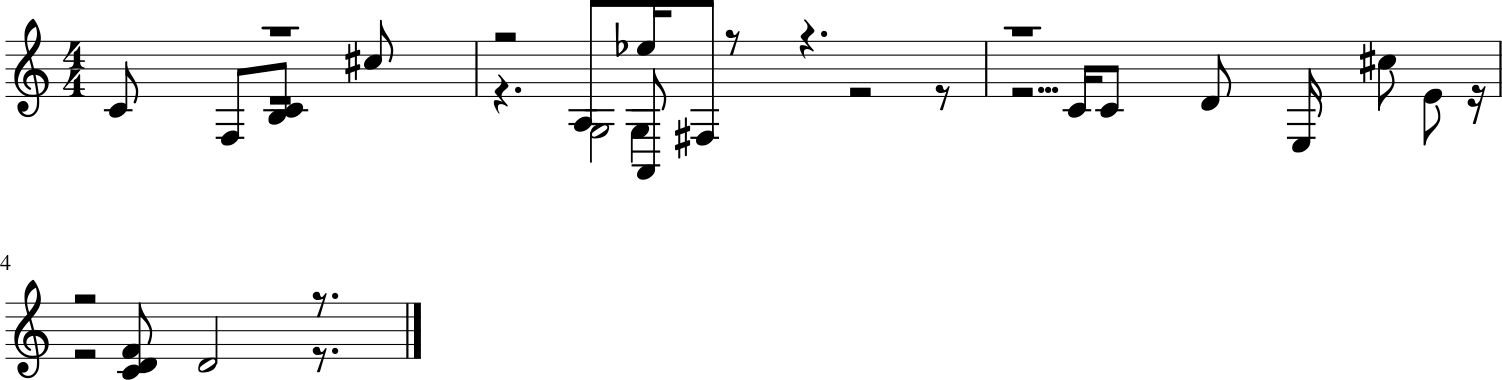

In [7]:
midi_file = Path('data/midi/notebook_examples/single_bar_example.mid')
item = MusicItem.from_file(midi_file, data.vocab);
pred = learn.predict(item, n_words=100)
pred.show()

In [ ]:
pred.play()